In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from models import AE, VAE, GeneratorModel, DiscriminatorModel
from trainers import AETrainer, VAETrainer, CGanTrainer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import PassiveAggressiveClassifier
import matplotlib.pyplot as plt
from utils import UNSWDataset
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.simplefilter("ignore")

# Task 1

## Data preprocessing

In [3]:
df_identity = pd.read_csv('data/task1/data_identity.csv')
df_transaction = pd.read_csv('data/task1/data_transaction.csv')

In [4]:
df = pd.merge(df_identity, df_transaction, on='TransactionID')

In [5]:
labeled_df = df.select_dtypes(exclude=['float64', 'int64', 'int32']).apply(
    lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index))

df[labeled_df.columns] = labeled_df

In [6]:
x = torch.torch.from_numpy(MinMaxScaler().fit_transform(df.drop('isFraud', axis=1).values)).to(torch.float32)
y = df['isFraud']

## Training/Testing Autoencoders

In [7]:
model = AE
f1_scores = {}
ae_trainer = AETrainer([x, y], model, regularization=False)

### Undercompleted Autoencoder

In [8]:
ae_trainer.train(train_epochs=321, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.06730160997372812 test_loss: 0.06695370376110077
epoch 20 train_loss: 0.042000258918357104 test_loss: 0.04124399274587631
epoch 40 train_loss: 0.016791969471800644 test_loss: 0.016344763338565826
epoch 60 train_loss: 0.00487252089928473 test_loss: 0.004707575310021639
epoch 80 train_loss: 0.0011052531540492732 test_loss: 0.001062961877323687
epoch 100 train_loss: 0.00021619631671109774 test_loss: 0.0002076866221614182
epoch 120 train_loss: 3.916889891598633e-05 test_loss: 3.794041549554095e-05
epoch 140 train_loss: 7.07174494167284e-06 test_loss: 7.1969179771258496e-06
epoch 160 train_loss: 1.4824232832035173e-06 test_loss: 1.8271747421749751e-06
epoch 180 train_loss: 4.737873598816676e-07 test_loss: 8.352795362043253e-07
epoch 200 train_loss: 2.528476224383103e-07 test_loss: 5.97795633439091e-07
epoch 220 train_loss: 1.8219267273223952e-07 test_loss: 5.053749987382616e-07
epoch 240 train_loss: 1.489255736076411e-07 test_loss: 4.4989820935370517e-07
epoch 260 trai

In [110]:
(filled_x_train, y_train), (filled_x_test, y_test)  = ae_trainer.fill_data()

In [111]:
all_data = np.vstack([filled_x_train.cpu(), filled_x_test.cpu()])

In [112]:
pca = PCA(n_components=100)
pca.fit(all_data)

PCA(n_components=100)

Text(0, 0.5, 'Variance')

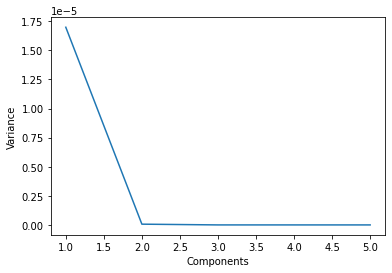

In [113]:
plt.plot(np.arange(1, 101)[:5], pca.explained_variance_[:5])
plt.xlabel('Components')
plt.ylabel('Variance')

In [117]:
sum(pca.explained_variance_[:5])

1.7047553760298082e-05

In [13]:
lda = LDA(n_components=1)
all_data_2d = lda.fit_transform(all_data, np.hstack([y_train, y_test]))

Text(0.5, 1.0, 'Data LDA')

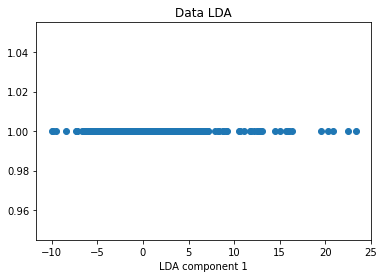

In [14]:
plt.scatter(all_data_2d, np.repeat(1, len(all_data_2d)))
plt.xlabel('LDA component 1')
plt.title('Data LDA')

In [15]:
clf = PassiveAggressiveClassifier()
clf.fit(filled_x_train.cpu(), y_train)

PassiveAggressiveClassifier()

In [16]:
f1_scores['AE'] = f1_score(clf.predict(filled_x_test.cpu()), y_test, average='macro')

### Regularized Autoencoder

In [17]:
ae_trainer_reg = AETrainer([x,y], model, regularization=True)

In [18]:
ae_trainer_reg.train(train_epochs=281, batch_size=512, verbose_time=20, lr=1e-6, l1=1e-2)

epoch 0 train_loss: 0.0675007151357368 test_loss: 0.06714383512735367
epoch 20 train_loss: 0.04183971611535655 test_loss: 0.04106121137738228
epoch 40 train_loss: 0.016356545830128993 test_loss: 0.015923714265227318
epoch 60 train_loss: 0.004709760435914571 test_loss: 0.004552267491817474
epoch 80 train_loss: 0.0010912568948182187 test_loss: 0.0010533233871683478
epoch 100 train_loss: 0.0003138405719794646 test_loss: 0.0003063335898332298
epoch 120 train_loss: 0.000237913353410364 test_loss: 0.00023398433404508978
epoch 140 train_loss: 9.632323053665459e-05 test_loss: 9.220717765856534e-05
epoch 160 train_loss: 1.7384953669502104e-05 test_loss: 1.664249793975614e-05
epoch 180 train_loss: 2.8082151827051493e-06 test_loss: 2.678335931705078e-06
epoch 200 train_loss: 3.993162389617556e-07 test_loss: 3.7990764667483745e-07
epoch 220 train_loss: 5.520197611900058e-08 test_loss: 5.259525792666864e-08
epoch 240 train_loss: 8.883872056876407e-09 test_loss: 8.517214489245362e-09
epoch 260 train

In [118]:
(filled_x_train, y_train), (filled_x_test, y_test)  = ae_trainer_reg.fill_data()

In [119]:
all_data = np.vstack([filled_x_train.cpu(), filled_x_test.cpu()])

In [120]:
pca = PCA(n_components=100)
pca.fit(all_data)

PCA(n_components=100)

Text(0, 0.5, 'Variance')

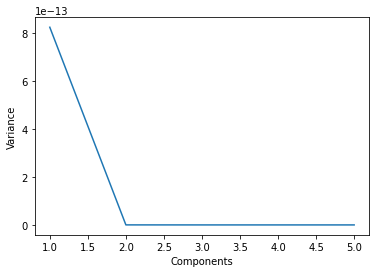

In [121]:
plt.plot(np.arange(1, 101)[:5], pca.explained_variance_[:5])
plt.xlabel('Components')
plt.ylabel('Variance')

In [122]:
sum(pca.explained_variance_[:5])

8.261180323829365e-13

In [23]:
lda = LDA(n_components=1)
all_data_2d = lda.fit_transform(all_data, np.hstack([y_train, y_test]))

Text(0.5, 1.0, 'Data LDA')

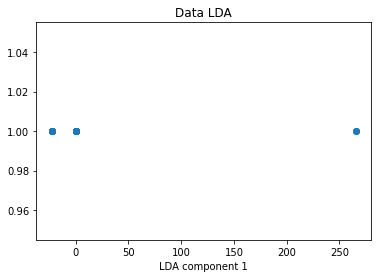

In [24]:
plt.scatter(all_data_2d, np.repeat(1, len(all_data_2d)))
plt.xlabel('LDA component 1')
plt.title('Data LDA')

In [25]:
clf = PassiveAggressiveClassifier()
clf.fit(filled_x_train.cpu(), y_train)

PassiveAggressiveClassifier()

In [26]:
f1_scores['RegAE'] = f1_score(clf.predict(filled_x_test.cpu()), y_test, average='macro')

### Variational Autoencoder

In [27]:
vae_model = VAE

vae_trainer = VAETrainer([x,y], vae_model)

In [28]:
vae_trainer.train(train_epochs=221, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.00186153774384607 test_loss: 0.0018764460692182183
epoch 20 train_loss: 0.0005848132389642925 test_loss: 0.0005689678946509957
epoch 40 train_loss: 0.00016808404956287004 test_loss: 0.00016217837401200086
epoch 60 train_loss: 3.607705868682742e-05 test_loss: 3.425503018661402e-05
epoch 80 train_loss: 6.023855779359408e-06 test_loss: 5.743021574744489e-06
epoch 100 train_loss: 1.0903924562244033e-06 test_loss: 1.0251487765344791e-06
epoch 120 train_loss: 3.2569725386687284e-07 test_loss: 3.2188219734052836e-07
epoch 140 train_loss: 1.458166159813934e-07 test_loss: 1.5605476733071555e-07
epoch 160 train_loss: 8.01171611894438e-08 test_loss: 7.96840211592098e-08
epoch 180 train_loss: 5.98050533695667e-08 test_loss: 5.4255608006315015e-08
epoch 200 train_loss: 3.210071429129346e-08 test_loss: 5.2659355986861556e-08
epoch 220 train_loss: 2.5538317138810478e-08 test_loss: 5.537119562859516e-08


In [123]:
(filled_x_train, y_train), (filled_x_test, y_test)  = vae_trainer.fill_data()

In [124]:
all_data = np.vstack([filled_x_train.cpu(), filled_x_test.cpu()])

In [125]:
pca = PCA(n_components=100)
pca.fit(all_data)

PCA(n_components=100)

Text(0, 0.5, 'Variance')

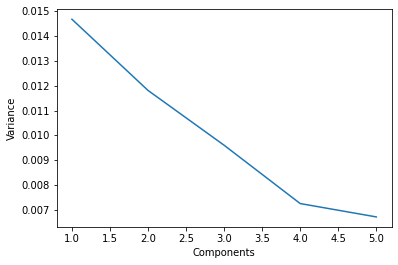

In [126]:
plt.plot(np.arange(1, 101)[:5], pca.explained_variance_[:5])
plt.xlabel('Components')
plt.ylabel('Variance')

In [127]:
sum(pca.explained_variance_[:5])

0.05006403486372541

In [33]:
lda = LDA(n_components=1)
all_data_2d = lda.fit_transform(all_data, np.hstack([y_train, y_test]))

Text(0.5, 1.0, 'Data LDA')

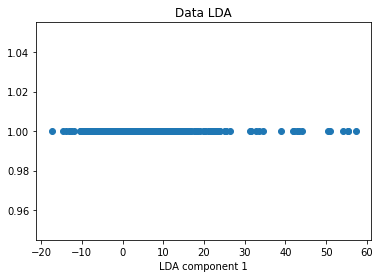

In [34]:
plt.scatter(all_data_2d, np.repeat(1, len(all_data_2d)))
plt.xlabel('LDA component 1')
plt.title('Data LDA')

In [35]:
clf = PassiveAggressiveClassifier()
clf.fit(filled_x_train.cpu(), y_train)

PassiveAggressiveClassifier()

In [36]:
f1_scores['VAE'] = f1_score(clf.predict(filled_x_test.cpu()), y_test, average='macro')

### Mean/0 filling

In [37]:
df_stat = df.drop('isFraud', axis=1).apply(lambda x: x.fillna(x.mean())) #Fill nans with mean of column
df_stat = df_stat.fillna(0) #fill full-nans columns with 0
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(df_stat, y, test_size=0.2, random_state=43)

In [38]:
clf = PassiveAggressiveClassifier()
clf.fit(MinMaxScaler().fit_transform(X_train_stat), y_train_stat)

PassiveAggressiveClassifier()

In [39]:
f1_scores['Mean/0'] = f1_score(clf.predict(MinMaxScaler().fit_transform(X_test_stat)), y_test_stat, average='macro')

In [128]:
all_data = MinMaxScaler().fit_transform(df_stat)

In [129]:
pca = PCA(n_components=100)
pca.fit(all_data)

PCA(n_components=100)

Text(0, 0.5, 'Variance')

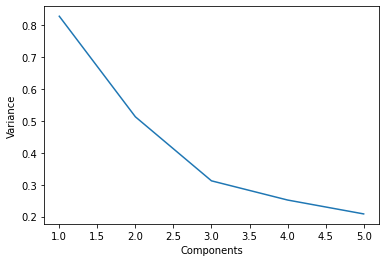

In [130]:
plt.plot(np.arange(1, 101)[:5], pca.explained_variance_[:5])
plt.xlabel('Components')
plt.ylabel('Variance')

In [131]:
sum(pca.explained_variance_[:5])

2.1153817680544327

In [43]:
lda = LDA(n_components=1)
all_data_2d = lda.fit_transform(all_data, np.hstack([y_train, y_test]))

Text(0.5, 1.0, 'Data LDA')

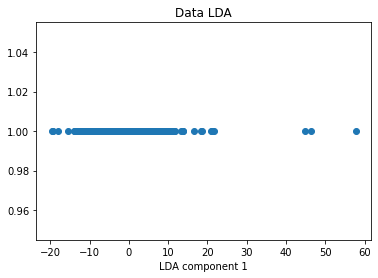

In [44]:
plt.scatter(all_data_2d, np.repeat(1, len(all_data_2d)))
plt.xlabel('LDA component 1')
plt.title('Data LDA')

### Performance visualisations

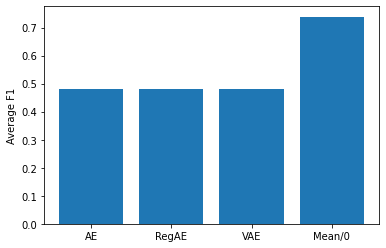

In [45]:
plt.bar(np.arange(len(f1_scores)), f1_scores.values())
plt.xticks(np.arange(len(f1_scores)), f1_scores.keys())
plt.ylabel('Average F1')
plt.show()

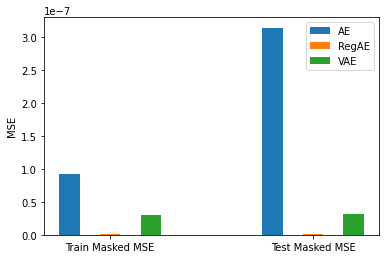

In [46]:
X = ['Train Masked MSE','Test Masked MSE']
ae_best = np.argmin(ae_trainer.history['test_loss'])
ae = [ae_trainer.history['train_loss'][ae_best], ae_trainer.history['test_loss'][ae_best]]

ae_reg_best = np.argmin(ae_trainer_reg.history['test_loss'])
ae_reg = [ae_trainer_reg.history['train_loss'][ae_reg_best], ae_trainer_reg.history['test_loss'][ae_reg_best]]

vae_best = np.argmin(vae_trainer.history['test_loss'])
vae = [vae_trainer.history['train_loss'][vae_best], vae_trainer.history['test_loss'][vae_best]]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, ae, 0.1, label = 'AE')
plt.bar(X_axis, ae_reg, 0.1, label = 'RegAE')
plt.bar(X_axis + 0.2, vae, 0.1, label = 'VAE')

plt.xticks(X_axis, X)
plt.ylabel("MSE")
plt.legend()
plt.show()

# Task 2

## Data preprocessing

Maybe it is mistake in files' names, because 'testing' file contains more data than 'training', so we will use 'testing' file for training and 'training' file for testing

In [47]:
df2 = pd.read_csv('data/task2/UNSW_NB15_testing-set.csv')

In [48]:
# Label not digit data
labeled_df2 = df2.select_dtypes(exclude=['float64', 'int64', 'int32']).apply(
    lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index))

df2[labeled_df2.columns] = labeled_df2

In [49]:
# scale data
scaleded_df2 = MinMaxScaler().fit_transform(df2.select_dtypes(include=['float64', 'int64', 'int32']))

df2[df2.select_dtypes(include=['float64', 'int64', 'int32']).columns] = scaleded_df2

In [50]:
# delete zero-columns
columns_drop = list(df2.columns[np.where(df2.quantile(0.9)==0)]) + ['id']

In [51]:
generator = GeneratorModel
discriminator = DiscriminatorModel

In [52]:
x2 = torch.torch.from_numpy(df2.drop(columns_drop, axis=1).values)
y2 = torch.torch.from_numpy(LabelEncoder().fit_transform(df2['attack_cat']))

## Train cGAN

In [53]:
cgan_trainers = [CGanTrainer([x2, y2], generator, discriminator) for _ in range(3)]

In [54]:
for i, cgan_trainer in enumerate(cgan_trainers):
    print(i, 'CGAN')
    cgan_trainer.train(train_epoch=3000, batch_size=512, embedding_dim=10, input_dim_g=100, verbose_time=200, gen_updates=2, add_noise=False)

0 CGAN
[0/3000]: loss_d: 0.691, loss_g: 0.681, kl: 2.673
[200/3000]: loss_d: 0.378, loss_g: 1.847, kl: 0.203
[400/3000]: loss_d: 0.347, loss_g: 2.379, kl: 0.214
[600/3000]: loss_d: 0.368, loss_g: 1.914, kl: 0.201
[800/3000]: loss_d: 0.429, loss_g: 2.102, kl: 0.219
[1000/3000]: loss_d: 0.338, loss_g: 2.521, kl: 0.206
[1200/3000]: loss_d: 0.285, loss_g: 2.505, kl: 0.174
[1400/3000]: loss_d: 0.364, loss_g: 2.241, kl: 0.160
[1600/3000]: loss_d: 0.408, loss_g: 1.912, kl: 0.149
[1800/3000]: loss_d: 0.347, loss_g: 2.145, kl: 0.157
[2000/3000]: loss_d: 0.332, loss_g: 2.134, kl: 0.170
[2200/3000]: loss_d: 0.420, loss_g: 2.019, kl: 0.156
[2400/3000]: loss_d: 0.415, loss_g: 2.034, kl: 0.167
[2600/3000]: loss_d: 0.399, loss_g: 2.215, kl: 0.169
[2800/3000]: loss_d: 0.345, loss_g: 2.502, kl: 0.155
1 CGAN
[0/3000]: loss_d: 0.692, loss_g: 0.759, kl: 2.605
[200/3000]: loss_d: 0.569, loss_g: 1.911, kl: 0.250
[400/3000]: loss_d: 0.198, loss_g: 3.167, kl: 0.255
[600/3000]: loss_d: 0.642, loss_g: 2.638, kl

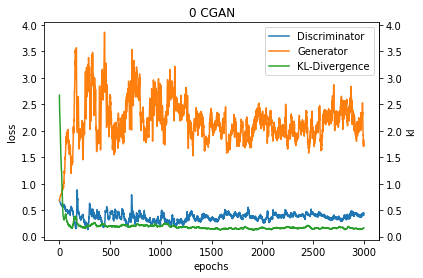

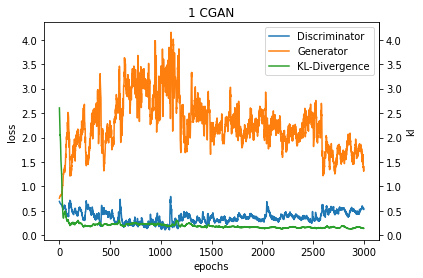

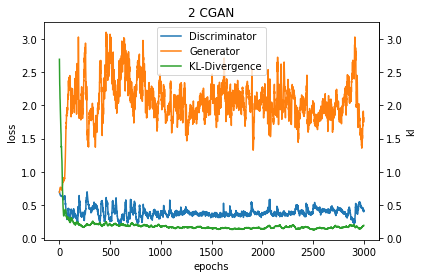

In [55]:
for i, cgan_trainer in enumerate(cgan_trainers):
    fig, ax = plt.subplots()
    ax.plot(cgan_trainer.history['loss_d'], label='Discriminator')
    ax.plot(cgan_trainer.history['loss_g'], label='Generator')
    ax2 = ax.secondary_yaxis("right")
    ax.plot(cgan_trainer.history['kl'], label='KL-Divergence')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax2.set_ylabel('kl')
    ax.set_title(f"{i} CGAN")
    plt.legend()
    plt.show()

## Test classifiers

In [56]:
X_train_df2_raw = df2.drop(columns_drop, axis=1).values
y_train_df2_raw = LabelEncoder().fit_transform(df2['attack_cat'])

### Generate train data

In [57]:
X_train_df2s = [df2.drop(columns_drop, axis=1).values for _ in range(3)]
y_train_df2s = [LabelEncoder().fit_transform(df2['attack_cat']) for _ in range(3)]

In [58]:
samp_per_lab = 10000 #samples per class for speed up learning

In [59]:
max_samp = max([np.where(y_train_df2s[0]==i)[0].shape[0] for i in range(10)])

In [60]:
# gen data
cgans_data = []
for cgan_trainer in cgan_trainers:
    generated_data = {}
    for i in range(10):
        size = max_samp - np.where(y_train_df2s[0]==i)[0].shape[0]
        data = cgan_trainer.generate_data(i, size)
        generated_data[i] = data
    cgans_data.append(generated_data)

In [61]:
# add generared data and clip real data
for j in range(3):
    for i in cgans_data[j]:
        if np.where(y_train_df2s[j]==i)[0].shape[0] < samp_per_lab:
            arr = np.array(cgans_data[j][i].tolist())[:samp_per_lab - np.where(y_train_df2s[j]==i)[0].shape[0]]
            label = np.repeat(i, arr.shape[0])
            X_train_df2s[j] = np.vstack([X_train_df2s[j], arr])
            y_train_df2s[j] = np.hstack([y_train_df2s[j], label])
        else:
            rand_ids = np.random.choice(np.where(y_train_df2s[j]==i)[0], len(np.where(y_train_df2s[j]==i)[0]) - samp_per_lab, replace=False)
            X_train_df2s[j] = np.delete(X_train_df2s[j], rand_ids, axis=0)
            y_train_df2s[j] = np.delete(y_train_df2s[j], rand_ids, axis=0)

In [62]:
# shuffle
for j in range(3):
    shuf_ids = np.random.shuffle(np.arange(len(y_train_df2s[j])))
    X_train_df2s[j] = X_train_df2s[j][shuf_ids]
    y_train_df2s[j] = y_train_df2s[j][shuf_ids]

    X_train_df2s[j] = X_train_df2s[j].squeeze()
    y_train_df2s[j] = y_train_df2s[j].squeeze()

### Test data preprocessing

In [63]:
X_test_df2 = pd.read_csv('data/task2/UNSW_NB15_training-set.csv')

In [64]:
# label not digit data
test_labeled_df2 = X_test_df2.select_dtypes(exclude=['float64', 'int64', 'int32']).apply(
    lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index))

X_test_df2[test_labeled_df2.columns] = test_labeled_df2
y_test_df2 = LabelEncoder().fit_transform(X_test_df2['attack_cat'].values)

In [65]:
# scale data
test_scaleded_df2 = MinMaxScaler().fit_transform(X_test_df2.select_dtypes(include=['float64', 'int64', 'int32']))

X_test_df2[X_test_df2.select_dtypes(include=['float64', 'int64', 'int32']).columns] = test_scaleded_df2

### RandomForest

#### Train without generated data

In [66]:
f1_scores2 = {}

In [67]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

clf.fit(X_train_df2_raw, y_train_df2_raw)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [68]:
pred = clf.predict(X_test_df2.drop(columns_drop, axis=1))

In [69]:
f1_scores2['RF_Raw'] = f1_score(pred, y_test_df2, average=None)
print(classification_report(pred, y_test_df2))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       617
           1       0.98      0.80      0.88       716
           2       0.97      0.98      0.97      4015
           3       1.00      1.00      1.00     11137
           4       1.00      1.00      1.00      6090
           5       1.00      1.00      1.00     18840
           6       1.00      1.00      1.00     37000
           7       0.99      1.00      1.00      3472
           8       1.00      0.93      0.96       408
           9       0.84      1.00      0.91        37

    accuracy                           1.00     82332
   macro avg       0.97      0.97      0.97     82332
weighted avg       1.00      1.00      1.00     82332



#### Train with generated data

In [70]:
for j in range(3):
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)

    clf.fit(X_train_df2s[j], y_train_df2s[j])

    pred = clf.predict(X_test_df2.drop(columns_drop, axis=1))

    f1_scores2[f'RF_Gen_{j}'] = f1_score(pred, y_test_df2, average=None)
print(classification_report(pred, y_test_df2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       667
           1       0.99      0.96      0.98       601
           2       1.00      1.00      1.00      4079
           3       1.00      1.00      1.00     11152
           4       1.00      0.98      0.99      6206
           5       0.99      1.00      1.00     18705
           6       1.00      1.00      1.00     37000
           7       0.99      1.00      1.00      3471
           8       1.00      0.92      0.96       412
           9       0.86      0.97      0.92        39

    accuracy                           1.00     82332
   macro avg       0.98      0.98      0.98     82332
weighted avg       1.00      1.00      1.00     82332



### Explainable Boosting Machine

#### Train without generated data

In [71]:
ebm = ExplainableBoostingClassifier(random_state=42, n_jobs=-1)

ebm.fit(X_train_df2_raw, y_train_df2_raw)

ExplainableBoostingClassifier(feature_names=['feature_0001', 'feature_0002',
                                             'feature_0003', 'feature_0004',
                                             'feature_0005', 'feature_0006',
                                             'feature_0007', 'feature_0008',
                                             'feature_0009', 'feature_0010',
                                             'feature_0011', 'feature_0012',
                                             'feature_0013', 'feature_0014',
                                             'feature_0015', 'feature_0016',
                                             'feature_0017', 'feature_0018',
                                             'feature_0019', 'feature_0020',
                                             'feat...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                              

In [72]:
pred = ebm.predict(X_test_df2.drop(columns_drop, axis=1))

In [73]:
f1_scores2['EBM_Raw'] = f1_score(pred, y_test_df2, average=None)
print(classification_report(pred, y_test_df2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       677
           1       0.99      1.00      0.99       577
           2       1.00      1.00      1.00      4095
           3       1.00      1.00      1.00     11117
           4       0.99      0.82      0.90      7335
           5       0.93      0.99      0.96     17643
           6       1.00      1.00      1.00     37000
           7       1.00      0.98      0.99      3551
           8       0.80      0.99      0.88       304
           9       0.75      1.00      0.86        33

    accuracy                           0.98     82332
   macro avg       0.95      0.98      0.96     82332
weighted avg       0.98      0.98      0.98     82332



#### Train with generated data

In [74]:
for j in range(3):
    ebm = ExplainableBoostingClassifier(random_state=42, n_jobs=-1)

    ebm.fit(X_train_df2s[j], y_train_df2s[j])

    pred = ebm.predict(X_test_df2.drop(columns_drop, axis=1))

    f1_scores2[f'EBM_Gen_{j}'] = f1_score(pred, y_test_df2, average=None)
print(classification_report(pred, y_test_df2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       677
           1       1.00      0.98      0.99       594
           2       1.00      1.00      1.00      4090
           3       1.00      1.00      1.00     11125
           4       1.00      0.97      0.99      6227
           5       0.99      1.00      0.99     18604
           6       1.00      1.00      1.00     37000
           7       1.00      0.99      1.00      3512
           8       1.00      0.82      0.90       460
           9       0.91      0.93      0.92        43

    accuracy                           1.00     82332
   macro avg       0.99      0.97      0.98     82332
weighted avg       1.00      1.00      1.00     82332



### Simple NN

In [75]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=self.linear2(x)
        return x

#### Train without generated data

In [76]:
input_dim=X_train_df2_raw.shape[1]     # how many Variables are in the dataset
hidden_dim = 25 # hidden layers
output_dim=10    # number of classes

In [77]:
simple_net = Net(input_dim,hidden_dim,output_dim).to(device)

dataset = UNSWDataset(X_train_df2_raw, y_train_df2_raw, device=device)
test_dataset = UNSWDataset(X_test_df2.drop(columns_drop, axis=1).values, y_test_df2, device=device)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()

learning_rate=0.01
optimizer=torch.optim.SGD(simple_net.parameters(), lr=learning_rate)

In [79]:
n_epochs=100
loss_list=[]
test_loss = []
for epoch in tqdm(range(n_epochs)):
    l = []
    for x, y in data_loader:
        #clear gradient 
        y = y.to(torch.long)
        optimizer.zero_grad()
        #make a prediction 
        z=simple_net(x)
        # calculate loss
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()

        l.append(loss.item())
    loss_list.append(np.mean(l))
    test_loss.append(f1_score(torch.argmax(F.softmax(simple_net(test_dataset.X)), axis=1).cpu(), y_test_df2, average='macro'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


In [80]:
f1_scores2[f"NN_Raw"] = f1_score(torch.argmax(F.softmax(simple_net(test_dataset.X)), axis=1).cpu(), y_test_df2, average=None)

#### Train with generated data

In [81]:
input_dim=X_train_df2s[0].shape[1]     # how many Variables are in the dataset
hidden_dim = 25 # hidden layers
output_dim=10    # number of classes

In [82]:
simple_nets = [Net(input_dim,hidden_dim,output_dim).to(device) for _ in range(3)]

datasets = [UNSWDataset(X_train_df2s[j], y_train_df2s[j], device=device) for j in range(3)]
data_loaders = [torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True) for dataset in datasets]

criterion = nn.CrossEntropyLoss()

learning_rate=0.01
optimizers=[torch.optim.SGD(simple_net.parameters(), lr=learning_rate) for simple_net in simple_nets]

In [83]:
loss_lists = []
test_losses = []
for j in range(3):
    n_epochs=100
    loss_list=[]
    test_loss = []
    #n_epochs
    for epoch in tqdm(range(n_epochs)):
        l = []
        for x, y in data_loaders[j]:
            #clear gradient 
            y = y.to(torch.long)
            optimizers[j].zero_grad()
            #make a prediction 
            z=simple_nets[j](x)
            # calculate loss
            loss=criterion(z,y)
            # calculate gradients of parameters 
            loss.backward()
            # update parameters 
            optimizers[j].step()

            l.append(loss.item())
        loss_list.append(np.mean(l))
        test_loss.append(f1_score(torch.argmax(F.softmax(simple_nets[j](test_dataset.X)), axis=1).cpu(), y_test_df2, average='macro'))
    loss_list.append(loss_list)
    test_losses.append(test_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


In [84]:
for j in range(3):
    f1_scores2[f"NN_Gen_{j}"] = f1_score(torch.argmax(F.softmax(simple_nets[j](test_dataset.X)), axis=1).cpu(), y_test_df2, average=None)

In [85]:
classifiers = ['RF', 'EBM', 'NN']
type_data = ['Raw', 'Gen']
mean_f1 = []
for classifier in classifiers:
    for d in type_data:
        if d == 'Gen':
            f1 = []
            for i in range(3):
                f1.append(f1_scores2[f'{classifier}_{d}_{i}'].mean())
        else:
            f1 = [f1_scores2[f'{classifier}_{d}']]
        mean_f1.append((classifier, d, np.mean(f1)))
            

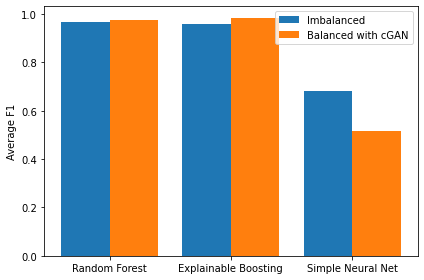

In [132]:
y = ['Imbalanced', 'Balanced with cGAN']
X = ['Random Forest','Explainable Boosting', 'Simple Neural Net']
raw = [mean_f1[0][2], mean_f1[2][2], mean_f1[4][2]]
gen = [mean_f1[1][2], mean_f1[3][2], mean_f1[5][2]]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, raw, 0.4, label = y[0])
plt.bar(X_axis + 0.2, gen, 0.4, label = y[1])

plt.xticks(X_axis, X)
plt.ylabel("Average F1")
plt.legend()
plt.tight_layout()
plt.show()